In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

from numpy import linalg as LA
from time import time
from pprint import pprint
from copy import deepcopy as copy


%matplotlib inline

## Read data files

**Note** We are keeping only the 50 states. DC not included. Self loops not included

In [2]:
def read_US_states(fname):
    states_abb_dict = {}
    states_abb_rev_dict = {}
    states_abb_ord_list = []
    with open(fname, "r") as f:
        for line in f:
            line = line.strip().split(",")
            name = line[0]
            abbr = line[1]
            states_abb_dict[name] = (abbr, len(states_abb_ord_list))
            states_abb_rev_dict[abbr] = name
            states_abb_ord_list.append(abbr)
    
    return states_abb_dict, states_abb_rev_dict, states_abb_ord_list

def read_travel_network(fname, states_abb_dict, states_abb_rev_dict, normalization=1):
    num_states = 50

    adjacency_list = {}
    A = np.zeros((num_states, num_states))

    for abb in states_abb_rev_dict:
        adjacency_list[abb] = []

    with open(fname, "r") as f:
        for idx, line in enumerate(f):
            if idx == 0:
                continue
            line = line.strip().split(",")
            orig = line[0]
            dest = line[1]
            weight = float(line[2])*10 / normalization
            if orig == dest:
                continue
            try:
                orig_abb, orig_idx = states_abb_dict[orig]
                dest_abb, dest_idx = states_abb_dict[dest]
                adjacency_list[orig_abb].append((dest_abb, weight))
                A[orig_idx][dest_idx] = weight
            except KeyError:
                pass
    
    return adjacency_list, A

def read_deaths_data(fname):
    df = pd.read_csv(fname)
    sum_df_d = df.groupby(['State', 'Year', 'Quarter'])[['DeathsFromPneumoniaAndInfluenza']].sum().T.to_dict()
    deaths_dict = {}
    for key, deaths in sum_df_d.items():
        state, year, quarter = key
        if state == "DC":
            continue
        if state not in deaths_dict:
            deaths_dict[state] = {}
        if year not in deaths_dict[state]:
            deaths_dict[state][year] = {}
        deaths_dict[state][year][quarter] = deaths["DeathsFromPneumoniaAndInfluenza"]
    return deaths_dict

def read_population_dict(fname):
    population_dict = {}
    with open(fname, "r") as f:
        for idx, line in enumerate(f):
            if idx == 0:
                continue
            line = line.strip().split(",")
            state = line[1]
            population_dict[state] = {}
            year = 2009
            for idx, pop in enumerate(line[2:]):
                population_dict[state][year + idx] = int(pop)
    return population_dict

## Simulation


1. Randomly infect people in each state with probability `p_inf`
    - Calculate fraction of infected people
2. Air travel the people
    - Fraction of infected air travelers is the same as origin state
    - Each person has a chance to infect every other person in the new state with probability `p_transfer`
3. In each state, either recover, kill, or remain infected the people there with probability `p_rec, p_die, p_stay`
4. Increment, or decrement, population between years (not quarters)

Totally, there are 4 parameters: `p_inf`, `p_transfer`, `p_rec`, `p_die`

Note `p_stay = 1 - p_rec - p_die`

Can make into a 3 parameter model by setting `p_stay = 0` i.e., between quarters, people either heal completely, or die.

### Goal: Find the best parameters that represent the number of deaths observed

In [3]:
class State:
    def __init__(self, pop):
        self.num_total = pop
        self.num_infected = 0
        self.num_deceased = 0
    
    def infected_fraction(self):
        return self.num_infected / self.num_total

### Kernels for simulation

In [228]:
def travel_and_infect_kernel(A, states, p_transfer, verbose=False):
    N = A.shape[0]
    new_states = copy(states)
    
    infected_fraction = np.zeros((N,))
    for i in range(N):
        infected_fraction[i] = states[i].infected_fraction()
    
    touch_fraction = 1
    
    for dest_id in range(N):
        
        # Let X be number of successful infections.
        # X is Binomial(n, p_transfer) where n is number of travelers.
        # We want X >= 1 for each person at destination i.e.,
        # at least one successful infection for each person at destination.
        # So, calculate p' = P(X >= 1) = 1 - P(X = 0) = 1 - (1-p_transfer)^n.
        # p' is the probability a person at destination gets infected.
        # This reduces problem to calculate a new r.v. Y.
        # Y is Binomial(m, p'), where m is the uninfected population of destination
        
        num_immigrants = A[:, i]
        num_infected_immigrants = np.matmul(num_immigrants, infected_fraction.T)
        # in expectation:
        # num_infected_immigrants = np.sum(A[:, i]) * p_inf
        ccdf = 1 - (1 - p_transfer)**num_infected_immigrants
        dest = states[dest_id]
        if dest.num_total - dest.num_infected > 0:
            if np.isnan(ccdf):
                ccdf = 1
            new_states[dest_id].num_infected += np.random.binomial(
                touch_fraction*(dest.num_total - dest.num_infected), ccdf)
#             # in expectation:
#             new_states[dest_id].num_infected += (dest.num_total - dest.num_infected) * ccdf
        
    return new_states

def recover_kernel(states, SIR_params):
    SIR_params = np.abs(SIR_params) / np.sum(np.abs(SIR_params))
    for i, state in enumerate(states):
        x = np.random.multinomial(states[i].num_infected, SIR_params)
        recovered = x[0]
        dead = x[2]
        state.num_total = max(state.num_total - dead, 0)
        states[i].num_infected -= (dead + recovered)
        states[i].num_deceased += dead
    return states

def local_infection_kernel(states, p_transfer):
    touch_fraction = 1
    for i, state in enumerate(states):
        states[i].num_infected = np.random.binomial(touch_fraction*(state.num_total - state.num_infected), p_transfer)
    return states

def remove_deceased_kernel(states):
    num_deceased = []
    for i, state in enumerate(states):
        num_deceased.append(state.num_deceased)
        state.num_deceased = 0
        states[i] = state
    return states, num_deceased
    
def inject_population_kernel(states, new_population):
    # new_population is somehow ordered
    for i, state in enumerate(states):
        current_pop = state.num_total
        nextgen_pop = new_population[i]
        extra_peeps = nextgen_pop - current_pop
        if extra_peeps > 0:
            state.num_total += extra_peeps
        elif extra_peeps < 0:
            # population actually decreased... remove infected and susceptible at same rate
            extra_peeps = -extra_peeps
            if extra_peeps // 2 >= state.num_infected:
                state.num_total = state.num_total - (extra_peeps - state.num_infected)
                state.num_infected = 0
            else:
                state.num_infected -= (extra_peeps - extra_peeps//2)
                state.num_total -= extra_peeps
        states[i] = state
    return states

def random_infection_kernel(states, p_inf):
    for i, state in enumerate(states):
        if state.num_total < state.num_infected:
            continue
        infected = np.random.binomial(state.num_total - state.num_infected, p_inf)
        state.num_infected += infected
        states[i] = state
    return states

### Real data

In [229]:
data_dir = "../Data/Clean/"
deaths_fname = "deaths_NCHS_processed.csv"
population_fname = "population.csv"

states_abb_dict, states_abb_rev_dict, stats_abb_ord_list = read_US_states(data_dir + "states_abb.csv")
deaths_dict = read_deaths_data(data_dir + deaths_fname)
population_dict = read_population_dict(data_dir + population_fname)

adj_list = {}
A = {}
A[2009] = {}
A[2009][4] = read_travel_network(data_dir + "2009_Q4.csv", states_abb_dict, states_abb_rev_dict)[1]
for year in range(2010, 2019):
    A[year] = {}
    for quarter in range(1, 5):
        network_fname = str(year) + "_Q" + str(quarter) + ".csv"
        A[year][quarter] = read_travel_network(data_dir + network_fname, states_abb_dict, states_abb_rev_dict)[1]
A[2019] = {}
A[2019][1] = read_travel_network(data_dir + "2019_Q1.csv", states_abb_dict, states_abb_rev_dict)[1]

all_population = {}
years = [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
for year in years:
    all_population[year] = []


for state,data in population_dict.items():
    for year, pop in data.items():
        all_population[year].append(pop)
        if year == 2018:
            all_population[2019].append(pop)
        
A_dict = A

In [230]:
deaths_matrix = {-1: [], 1: [], 2: [], 3: [], 4:[]}
for state, yearly_deaths_dict in deaths_dict.items():
    deaths_vector = {}
    for q in deaths_matrix:
        deaths_vector[q] = []
    for year, quarterly_deaths_dict in yearly_deaths_dict.items():
#         if year > 2012:
#             continue
        for quarter, deaths_count in quarterly_deaths_dict.items():
            deaths_vector[-1].append(deaths_count)
            deaths_vector[quarter].append(deaths_count)
    for q in deaths_matrix:
        deaths_matrix[q].append(deaths_vector[q])
        
for q in deaths_matrix:
    deaths_matrix[q] = np.array(deaths_matrix[q])
    print(deaths_matrix[q].shape)

(50, 38)
(50, 10)
(50, 9)
(50, 9)
(50, 10)


In [231]:
print(deaths_matrix[-1][0])
print(deaths_matrix[1][0])

[59. 56. 61. 44. 65. 78. 57. 65. 60. 62. 44. 46. 70. 69. 45. 67. 67. 63.
 67. 49. 86. 62. 56. 55. 61. 64. 54. 39. 80. 74. 66. 58. 61. 68. 70. 50.
 52. 66.]
[56. 78. 62. 69. 63. 62. 64. 74. 68. 66.]


In [283]:
def run_full_simulation(x, A_dict, all_population, error=False, sim_quarter=-1):
    p_inf = x[0]
    p_transfer = x[1]
    if p_inf < 0 or p_inf > 1 or p_transfer < 0 or p_transfer > 1:
        return 10
    p_rec = x[2]
    p_die = 7.540044190323758e-05
#     p_die = x[3]
    p_stay = 1 - p_rec - p_die
    SIR = [p_rec, p_stay, p_die]
#     SIR = np.abs(SIR / np.abs(np.sum(SIR)))
    states = []
    year_0 = 2009
    for state_id in range(50):
        state = State(all_population[year_0][state_id])
        state.num_infected += np.random.binomial(state.num_total, p_inf)
        states.append(state)

    # Propagate infection
    num_deceased = {}

    # For each year:
    for year in years:
        num_deceased[year] = {}
        # For each quarter:
        for quarter in range(1, 5):
            if year == 2009 and quarter != 4:
                continue
            if year == 2019 and quarter != 1:
                continue
#             if year > 2012:
#                 continue
            if sim_quarter != -1 and quarter != sim_quarter:
                continue
            # 1. travel and infect
            # 2. Recover
            # 3. Remove deceased and store it
            # 4. Randomly infect
            if quarter == 1:
                p_t = p_transfer*1
                p_i = p_inf*1
            elif quarter == 2:
                p_t = p_transfer*0.5
                p_i = p_inf*0.5
            elif quarter == 3:
                p_t = p_transfer*0.6
                p_i = p_inf*0.6
            elif quarter == 4:
                p_t = p_transfer*0.8
                p_i = p_inf*0.8
            
            states = travel_and_infect_kernel(A_dict[year][quarter], states, p_t)
            states = recover_kernel(states, SIR)
            
            for i in range(8):
                states = local_infection_kernel(states, p_t)
                states = recover_kernel(states, SIR)
            
            states, dead_peeps = remove_deceased_kernel(states)
            num_deceased[year][quarter] = dead_peeps
            states = random_infection_kernel(states, p_i)

        # Inject population
        try:
            pop_vec = inject_population_kernel(states, all_population[year+1])
        except KeyError:
            # We are at the end of our data
            pass
    
    sim_deaths_matrix = []

    for year, quarterly_deaths in num_deceased.items():
        for quarter, deaths_vector in quarterly_deaths.items():
            sim_deaths_matrix.append(deaths_vector)

    sim_deaths_matrix = np.array(sim_deaths_matrix).T
    
    if error:
        return LA.norm(deaths_matrix[sim_quarter] - sim_deaths_matrix, ord='fro') / LA.norm(deaths_matrix[sim_quarter], ord='fro')
    else:
        return sim_deaths_matrix

In [273]:
# Fix parameters of the model
P_inf = np.linspace(0.05, 0.2, num=100)
P_transfer = np.linspace(0, 1, num=100)
P_rec = np.linspace(0, 1, num=100)
p_die = 7.540044190323758e-05

x0 = np.array([P_inf[23], P_transfer[10], P_rec[33]])
matrix = run_full_simulation(x0, A_dict, all_population, sim_quarter=-1)#, error=True)
print(matrix.shape)

(50, 38)


### Random Walks?

In [274]:
def perturbe(x, mu=0, sigma=1e-4):
    return x + np.random.normal(mu, sigma, size=x.shape)

def isvalid(x):
    return (x <= 1).all() and (x >= 0).all()

error_tol = 0.5
quarter = -1

# x_best = np.array([1.50141914e-03, 5.08739999e-04, 9.85804602e-01])
# x_best = np.array([2.44585049e-02, 5.19930292e-05, 9.11488483e-01])
# x_best = np.array([2.47333730e-02, 8.97588162e-05, 9.79676153e-01])
# x_best = np.array([2.45480162e-02, 3.68910748e-04, 9.79240520e-01, 2.88207661e-05])
x_best = np.array([0.1, 0.1, 0.99])
# x_best = np.random.uniform(0, 1, size=(3,))
print(x_best)
error = run_full_simulation(x_best, A_dict, all_population, True, sim_quarter=quarter)
print("0", error)
error_best = round(error,2)

ctr = 0
invalid_ctr = 0

while error > error_tol:
    x_i = perturbe(x_best, mu=0, sigma=1e-1)
#     x_i = x_best + np.random.normal(0, 1e-3, size=x_best.shape)
    if not isvalid(x_i):
        invalid_ctr += 1
        if invalid_ctr % 10 == 0:
            print("Invalid: ", invalid_ctr)
        continue
    error = round(run_full_simulation(x_i, A_dict, all_population, True, sim_quarter=quarter), 2)
    ctr += 1
    if error < error_best:
        x_best = copy(x_i)
        error_best = error
        print(ctr, error)
    elif ctr % 10 == 0:
        print("Counter: ", ctr)

[0.1  0.1  0.99]
0 0.567945031295989
Counter:  10
Invalid:  10
Invalid:  20
Counter:  20
Invalid:  30
Counter:  30
Invalid:  40
Counter:  40
Invalid:  50
Invalid:  60
Invalid:  70
Counter:  50
Invalid:  80
Invalid:  90
Counter:  60
Invalid:  100


KeyboardInterrupt: 

In [275]:
print(x_best)
sim_deaths = run_full_simulation(np.array([0.1, 0.1, 0.99]), A_dict, all_population, sim_quarter=quarter)

[0.1  0.1  0.99]


In [276]:
sim_deaths_best = run_full_simulation(np.array(x_best), A_dict, all_population, sim_quarter=quarter)

In [277]:
fraction = np.abs(deaths_matrix[quarter] - sim_deaths_best)# / deaths_matrix[-1]
np.mean(fraction)

527.3321052631579

In [278]:
# simulated results = sim_deaths and real data = deaths_matrix
diff = (deaths_matrix[quarter] - sim_deaths_best).flatten()
print(np.mean(diff))
print(np.std(diff))

194.5794736842105
775.5946598033747


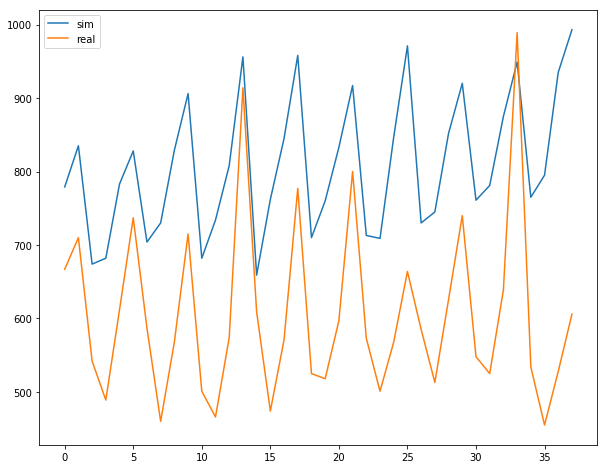

In [279]:
## Arizona
plt.figure(figsize=[10,8])
plt.plot(range(38), sim_deaths_best[2])
plt.plot(range(38), deaths_matrix[-1][2])
plt.legend(["sim", "real"])

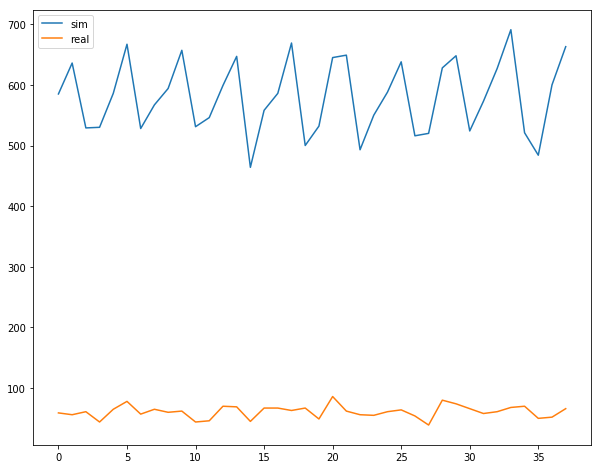

In [280]:
## Alabama
plt.figure(figsize=[10,8])
plt.plot(range(38), sim_deaths_best[0])
plt.plot(range(38), deaths_matrix[-1][0])
plt.legend(["sim", "real"])

need beautiful plots!

In [281]:
sim_deaths_best.shape

(50, 38)

In [282]:
deceased_df = pd.DataFrame(sim_deaths_best)
deceased_df.to_csv('deceased_df_real_data_4.csv')

In [260]:
# deceased_df = pd.DataFrame.from_records([[i, j] + num_deceased[i][j] for i in num_deceased for j in num_deceased[i]])
# deceased_df.to_csv('deceased_df_real_data_3.csv')

### Real Data No Travel

In [284]:
sim_time = time()

states = []
year_0 = 2009
for state_id in range(50):
    state = State(all_population[year_0][state_id])
    state.num_infected += np.random.binomial(state.num_total, p_inf)
    states.append(state)
    
# Propagate infection
num_deceased_no_travel = {}

# For each year:
for year in years:
    iter_time = time()
    num_deceased_no_travel[year] = {}
    # For each quarter:
    for quarter in range(1, 5):
        if year == 2009 and quarter != 4:
            continue
        if year == 2019 and quarter != 1:
            continue
        # 1. travel and infect
        # 2. Recover
        # 3. Remove deceased and store it
        # 4. Randomly infect
#         states = travel_and_infect_kernel(A_dict[year][quarter], states, p_transfer)
        if quarter == 1:
            p_t = p_transfer*1
            p_i = p_inf*1
        elif quarter == 2:
            p_t = p_transfer*0.5
            p_i = p_inf*0.5
        elif quarter == 3:
            p_t = p_transfer*0.6
            p_i = p_inf*0.6
        elif quarter == 4:
            p_t = p_transfer*0.8
            p_i = p_inf*0.8
        
        states = recover_kernel(states, SIR)
        states, dead_peeps = remove_deceased_kernel(states)
        num_deceased_no_travel[year][quarter] = dead_peeps
        states = random_infection_kernel(states, p_i)
    
    # Inject population
    try:
        pop_vec = inject_population_kernel(states, all_population[year+1])
    except KeyError:
        # We are at the end of our data
        pass
    
    iter_time = time() - iter_time
    print("Elapsed time for {}: {:.3f} s".format(year, iter_time))

sim_time = time() - sim_time
print("Total elapsed time for simulation: {:.3f} s".format(sim_time))

NameError: name 'p_inf' is not defined

In [ ]:
deceased_no_travel_df = pd.DataFrame.from_records([[i, j] + num_deceased_no_travel[i][j] for i in num_deceased_no_travel for j in num_deceased_no_travel[i]])
deceased_no_travel_df.to_csv('deceased_df_no_travel_real_data_3.csv')
